<a href="https://www.kaggle.com/code/rubanzasilva/s5e7-fastai-gradient-boosting?scriptVersionId=252209210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Personality Type Binary Classification

Our goal for this competition is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
#%pip install -q -U autogluon.tabular
#%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
#torch.manual_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s5e7/')
path

Path('/kaggle/input/playground-series-s5e7')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df_a = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv')
original_df_b = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv')

In [7]:
train_df.shape,original_df_a.shape,original_df_b.shape

((18524, 8), (2900, 8), (2900, 8))

In [8]:
original_df_b

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
2896,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,3.0,Yes,2.0,0.0,Introvert


In [9]:
#train_df = pd.concat([train_df, original_df], ignore_index=True)

## Exploratory Data Analysis

In [10]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [11]:
# Transpose to see data vertically
train_df.head().T

id,0,1,2,3,4
Time_spent_Alone,0.0,1.0,6.0,3.0,1.0
Stage_fear,No,No,Yes,No,No
Social_event_attendance,6.0,7.0,1.0,7.0,4.0
Going_outside,4.0,3.0,0.0,3.0,4.0
Drained_after_socializing,No,No,NaN,No,No
Friends_circle_size,15.0,10.0,3.0,11.0,13.0
Post_frequency,5.0,8.0,0.0,5.0,NaN
Personality,Extrovert,Extrovert,Introvert,Extrovert,Extrovert


In [12]:
train_df.columns, original_df_a.columns

(Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
        'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
        'Post_frequency', 'Personality'],
       dtype='object'),
 Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
        'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
        'Post_frequency', 'Personality'],
       dtype='object'))

#### Missing value check

In [13]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

Stage_fear                   1893
Going_outside                1466
Post_frequency               1264
Time_spent_Alone             1190
Social_event_attendance      1180
Drained_after_socializing    1149
Friends_circle_size          1054
Personality                     0
dtype: int64


In [14]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

Stage_fear                   10.219175
Going_outside                 7.914057
Post_frequency                6.823580
Time_spent_Alone              6.424098
Social_event_attendance       6.370114
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Personality                   0.000000
dtype: float64


#### Summary Statistics

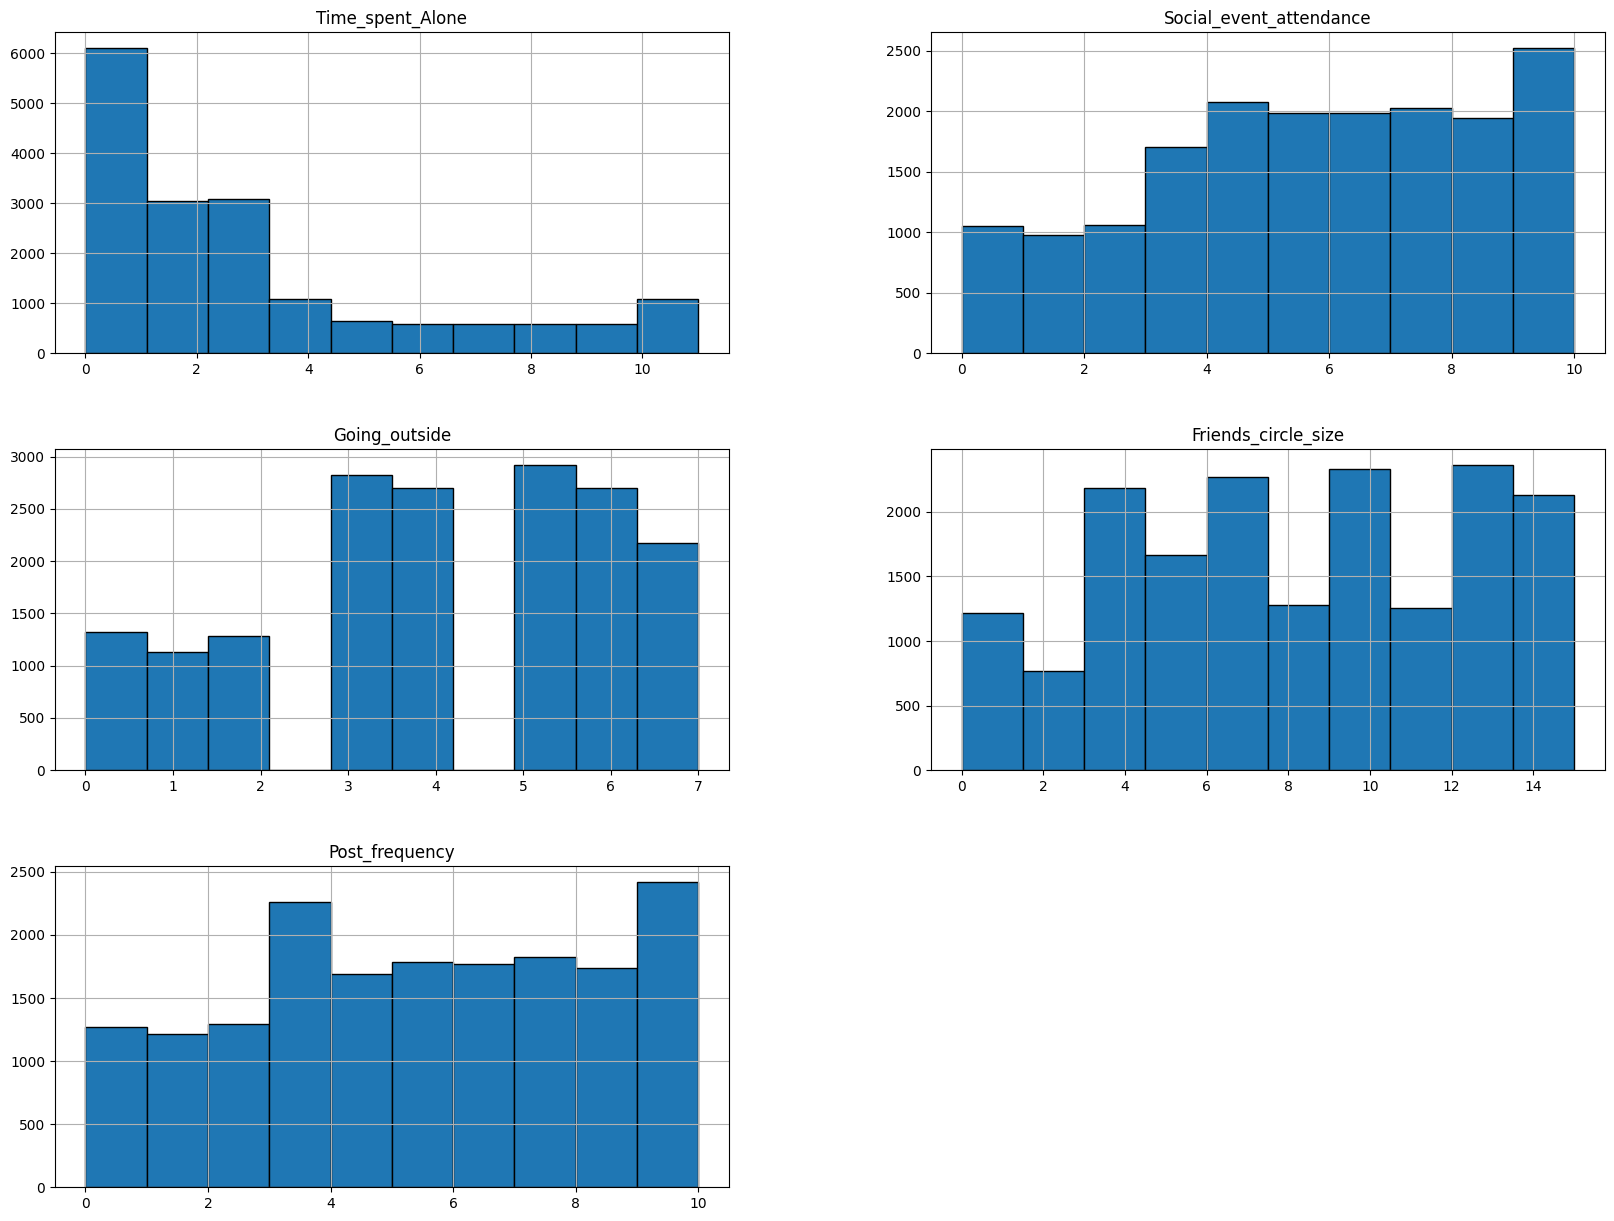

In [15]:
train_df.hist(figsize=(20,15),edgecolor='black');

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [17]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,17334.0,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,17344.0,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,4.044319,2.062580,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,17470.0,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0


#### Target Variable

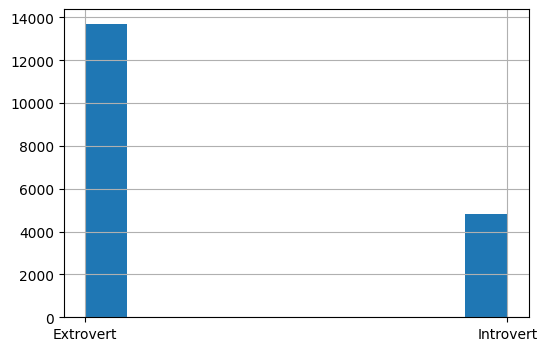

In [18]:
train_df['Personality'].hist(figsize=(6,4));

In [19]:
def cat_plot_count_dist(data, column, title=None, figsize=(15,10)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data)
    
    # Set title (use column name if title not provided)
    title = title or f'Distribution by {column}'
    plt.title(title, fontsize=16)
    
    # Set labels
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Set tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fontsize=14, padding=10)
        
    plt.tight_layout()
    plt.show()

In [20]:
def plot_pie_distribution(data, column, explode=None, figsize=(6,6), title=None):
   # Get value counts
   counts = data[column].value_counts()
   
   # Set default explode if not provided 
   if explode is None:
       explode = tuple([0] * len(counts))
   
   # Set default title if not provided
   title = title or f'Distribution of {column}'
   
   plt.figure(figsize=figsize)
   plt.pie(counts.values, labels=counts.index,
           explode=explode, autopct='%1.1f%%', startangle=90)
   plt.axis('equal')
   plt.title(title, fontsize=16)
   plt.show()

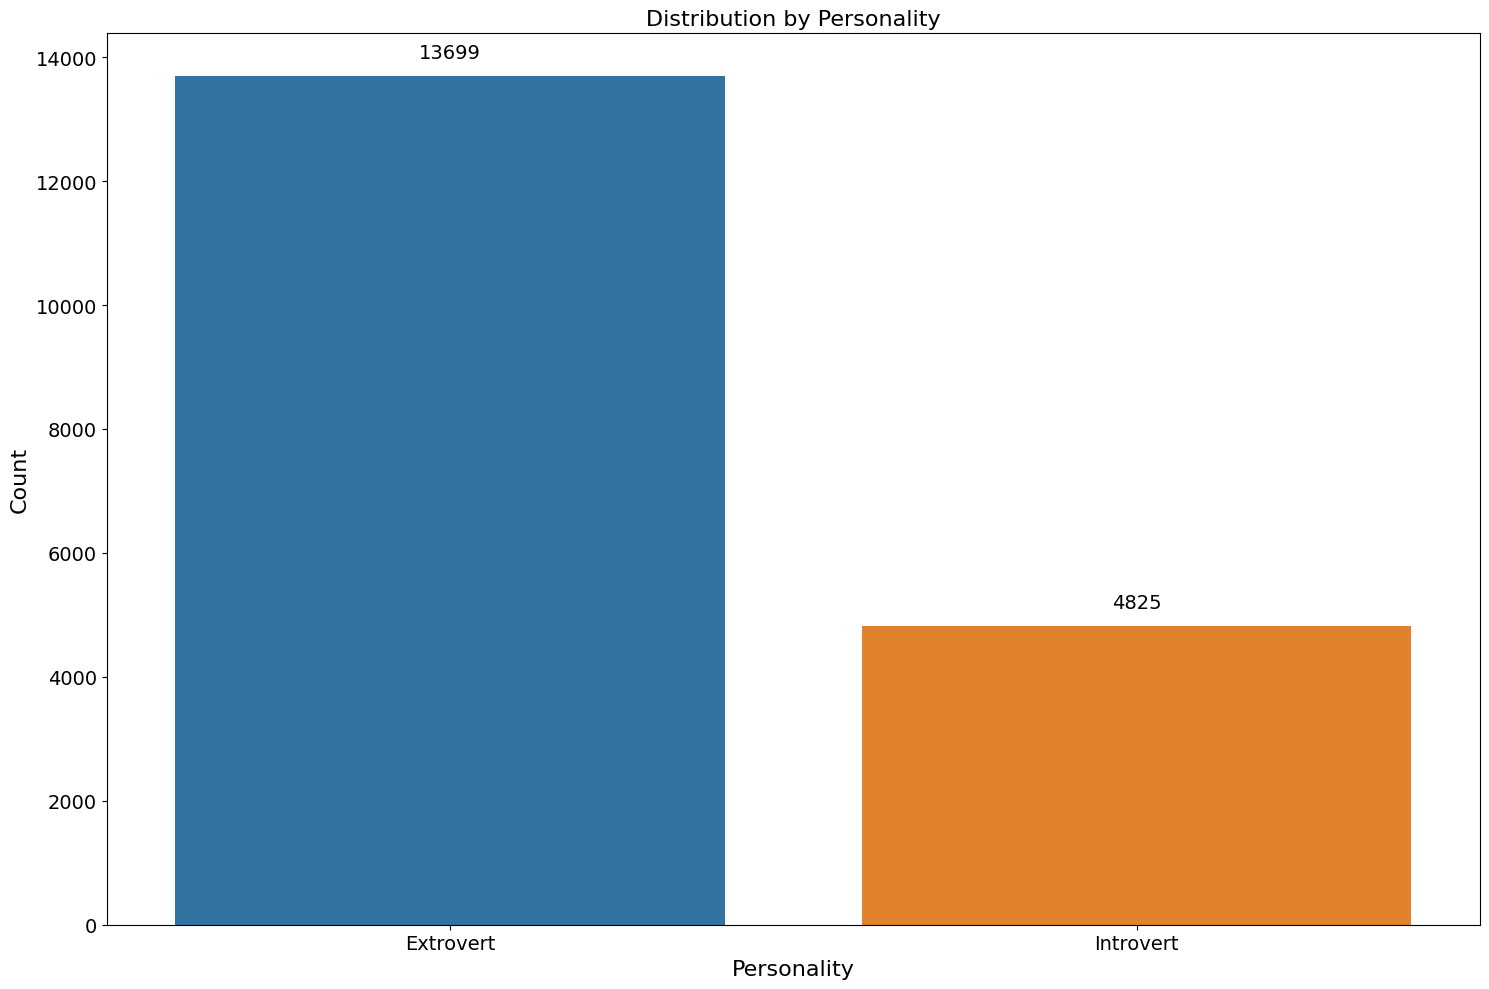

In [21]:
#cat_plot_count_dist(train_df, 'Depression', figsize=(12,8))
cat_plot_count_dist(train_df, 'Personality', 'Distribution by Personality')

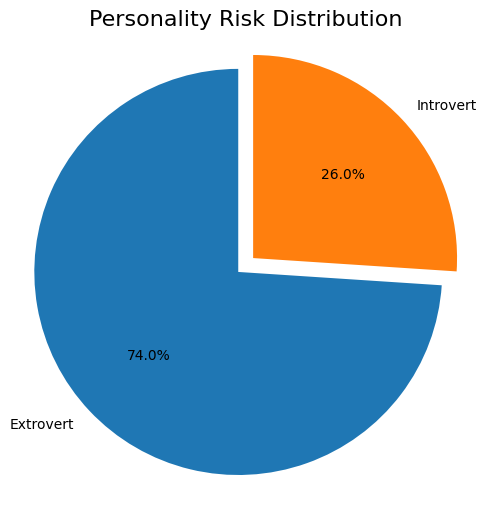

In [22]:
plot_pie_distribution(train_df, 'Personality', 
                    explode=(0,0.1), 
                    title='Personality Risk Distribution')

#### Univariate Analysis

In [23]:
train_df.describe(include=[object]).T

,count,unique,top,freq
Stage_fear,16631,2,No,12609
Drained_after_socializing,17375,2,No,13313
Personality,18524,2,Extrovert,13699


##### Stage_fear

In [24]:
train_df['Stage_fear'].nunique()

2

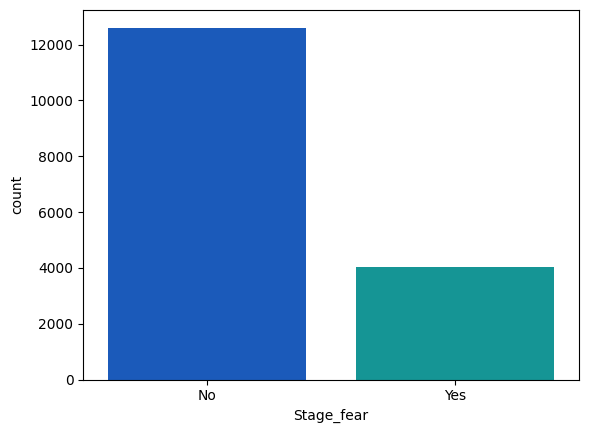

In [25]:
sns.countplot(x='Stage_fear', data=train_df, palette='winter')
plt.show()

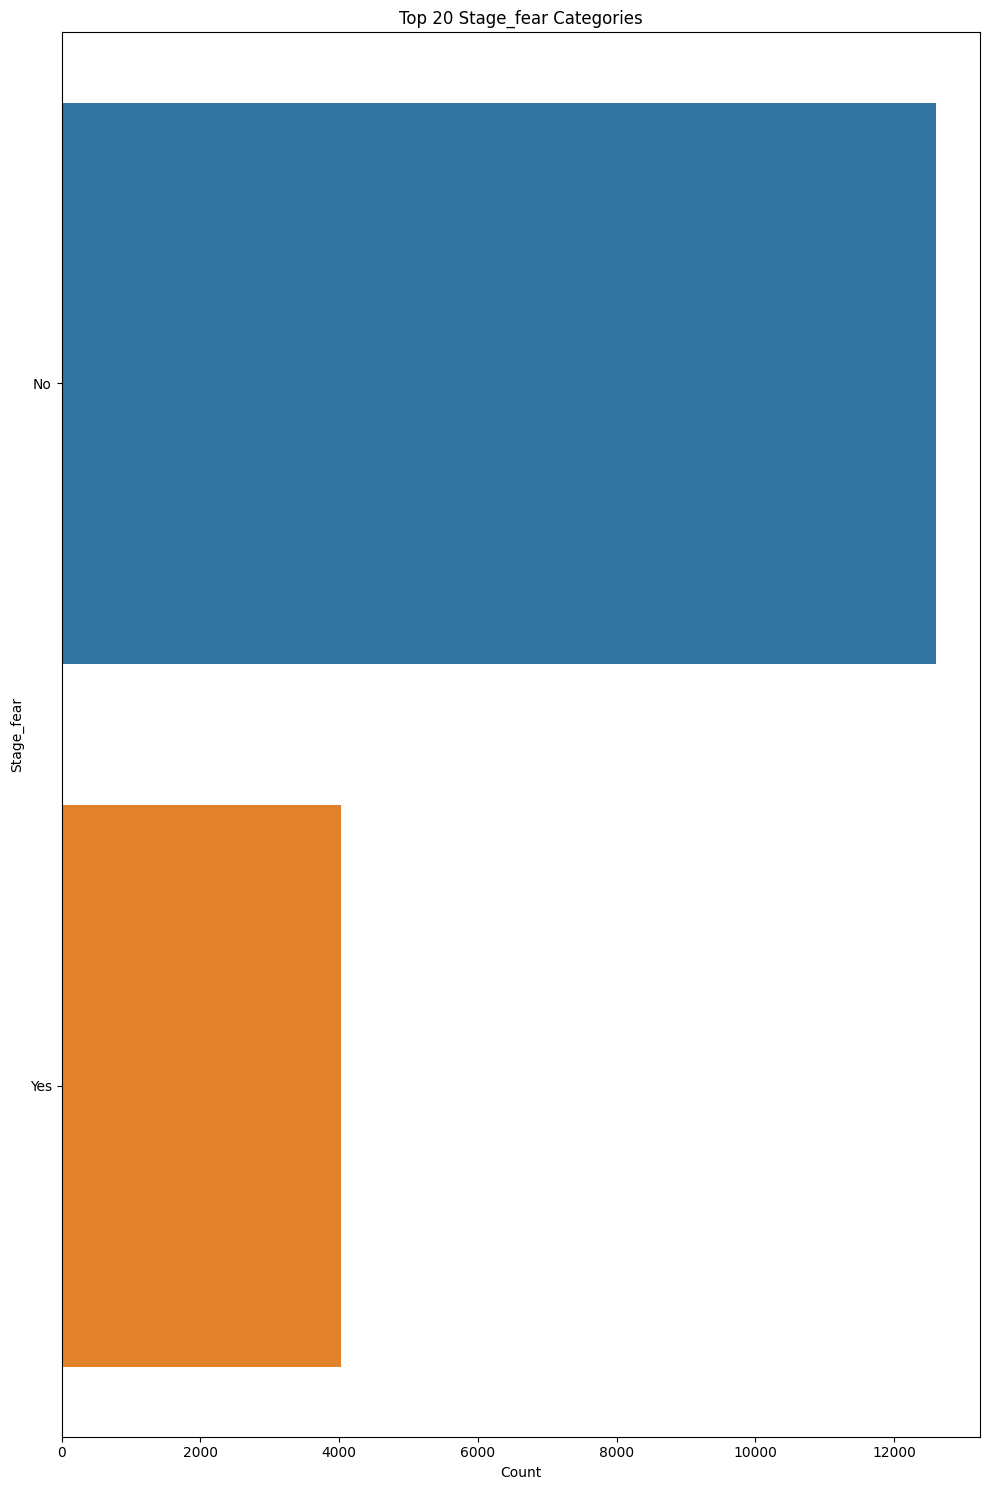

In [26]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Stage_fear', top_n=20)

##### Drained_after_socializing

In [27]:
train_df['Drained_after_socializing'].nunique()

2

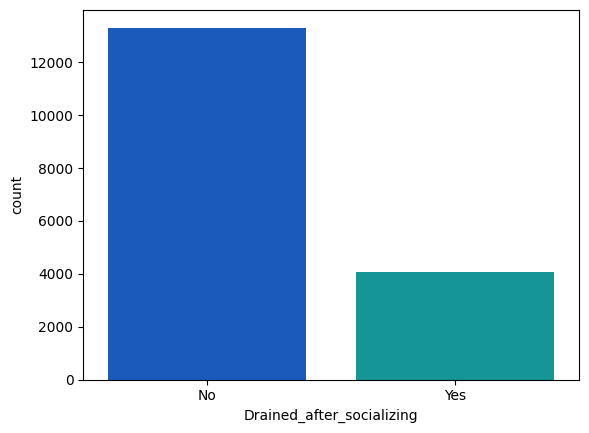

In [28]:
sns.countplot(x='Drained_after_socializing', data=train_df, palette='winter')
plt.show()

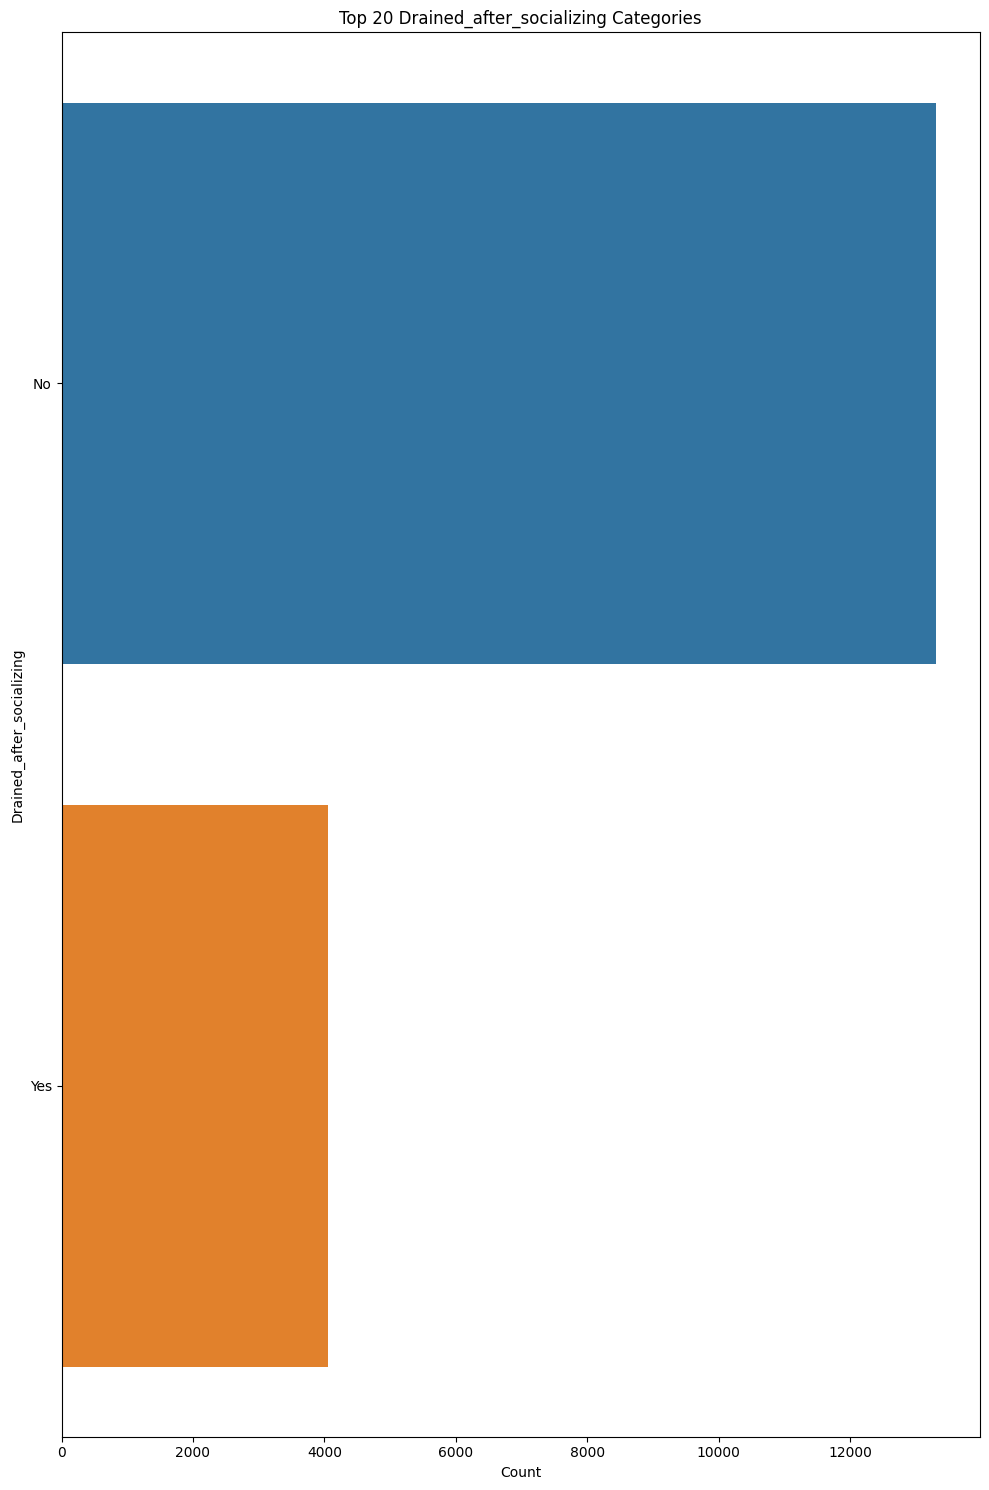

In [29]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Drained_after_socializing', top_n=20)

#### Continous variables

In [30]:
#train_df.value_counts()

In [31]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,17334.0,3.137764,3.003786,0.0,1.0,2.0,4.0,11.0
Social_event_attendance,17344.0,5.265106,2.753359,0.0,3.0,5.0,8.0,10.0
Going_outside,17058.0,4.044319,2.062580,0.0,3.0,4.0,6.0,7.0
Friends_circle_size,17470.0,7.996737,4.223484,0.0,5.0,8.0,12.0,15.0
Post_frequency,17260.0,4.982097,2.879139,0.0,3.0,5.0,7.0,10.0


#### Time_spent_Alone

In [32]:
train_df.Time_spent_Alone.var()

9.02273234466217

## Data Pre-processing with fast.ai

The `RandomSplitter` function below separates the training set into a training and validation set based on the value of the argument `valid_pct`.

In [33]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [34]:
#I decided to put concat the original df and the train df after doing the split so that validation can be done on the competition dataset only.
train_df = pd.concat([train_df, original_df_a], ignore_index=True)
#train_df = pd.concat(objs=[train_df, original_df])

In [35]:
train_df.shape

(21424, 8)

In [36]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
21419,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
21420,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
21421,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
21422,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


Below, we are going to prepare our data for machine learning.

First, we define the categorical and continuous variables. I use the fastai `cont_cat_split` function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

`cont_cat_split` takes an argument,`max_card` whose default value is 20. If the number of unique values is above 20 (the default `max_card` value) for a particular column, that column is considered continuous, and vice versa.

Define a `TabularPandas` object. Here we define the continuous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable, which is what we are predicting, and the type of problem we are optimizing for, such as binary classification in this case.

I then create and define a `dataloaders` object, which prepares the data for input into our neural network. Here, we also define our batch size.

In [37]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Personality')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Personality',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [38]:
cont_names,len(cont_names)

(['Time_spent_Alone',
  'Social_event_attendance',
  'Going_outside',
  'Friends_circle_size',
  'Post_frequency'],
 5)

In [39]:
cat_names, len(cat_names)

(['Stage_fear',
  'Drained_after_socializing',
  'Time_spent_Alone_na',
  'Social_event_attendance_na',
  'Going_outside_na',
  'Friends_circle_size_na',
  'Post_frequency_na'],
 7)

In [40]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
21419,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
21420,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
21421,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
21422,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


Finally, I extract the training and validation sets plus their values.

In [41]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

### Define Model Parameters

In [42]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_params = {'random_state':42}

#### Cross Validation Function

In [43]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        #cv_score = score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks¶

In [44]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.001737800776027143)

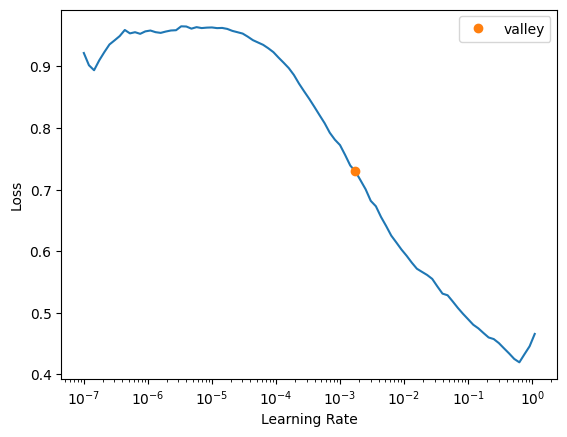

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(30, 1.089e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.241994,0.210115,0.964363,00:02
1,0.204362,0.193095,0.965443,00:02
2,0.178801,0.171693,0.964093,00:02
3,0.137193,0.148482,0.966253,00:02
4,0.135356,0.154372,0.966793,00:02
5,0.129808,0.149096,0.966523,00:02
6,0.132584,0.145244,0.966793,00:02
7,0.134605,0.145192,0.966793,00:02
8,0.147203,0.143892,0.967063,00:02
9,0.120677,0.146036,0.967063,00:02


In [47]:
dl = test_dl

In [48]:
learn.save('nn_pnality_tp_pd')

Path('models/nn_pnality_tp_pd.pth')

In [49]:
#learn.load('nn_pnality_tp_pd')  

In [50]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [51]:
a_preds.shape

torch.Size([6175, 2])

In [52]:
nn_preds_y.shape,sub_df.shape

(torch.Size([6175, 2]), (6175, 2))

In [53]:
nn_preds_x

tensor([[0.9651, 0.0349],
        [0.9871, 0.0129],
        [0.0795, 0.9205],
        ...,
        [0.9937, 0.0063],
        [0.9903, 0.0097],
        [0.0169, 0.9831]])

In [54]:
nn_preds_y

tensor([[0.9983, 0.0017],
        [0.0241, 0.9759],
        [0.9660, 0.0340],
        ...,
        [0.9983, 0.0017],
        [0.9970, 0.0030],
        [0.0137, 0.9863]])

In [55]:
final_preds = torch.round(a_preds).long()
final_preds = final_preds[:,1]
final_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [56]:
final_preds.shape

torch.Size([6175])

In [57]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'Extrovert', 1: 'Introvert'}

In [58]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in final_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [59]:
#!rm submission.csv
#sub_df['Personality'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='Id')
#sub

## Gradient Boosting

### Random Forest

In [60]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 8.48 s, sys: 65.7 ms, total: 8.54 s
Wall time: 8.54 s


0.9665226781857451

In [61]:
rf_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [62]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.969298
Fold 2 AUC: 0.966937
Fold 3 AUC: 0.968623
Fold 4 AUC: 0.964575
Fold 5 AUC: 0.971997

Mean AUC: 0.968286


In [63]:
rf_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [64]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [65]:
 rf_mean_score

0.9682860998650472

In [66]:
rf_fold_scores

[0.9692982456140351,
 0.9669365721997301,
 0.9686234817813765,
 0.9645748987854251,
 0.9719973009446694]

In [67]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((14820,), torch.Size([6175]), 0.9682860998650472)

#### Random forest feature importance

In [68]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [69]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
5,Friends_circle_size_na,0.000604
4,Going_outside_na,0.000855
6,Post_frequency_na,0.000873
3,Social_event_attendance_na,0.000887
2,Time_spent_Alone_na,0.001050
10,Friends_circle_size,0.053881
8,Social_event_attendance,0.101909
9,Going_outside,0.104170
11,Post_frequency,0.114000
7,Time_spent_Alone,0.170714


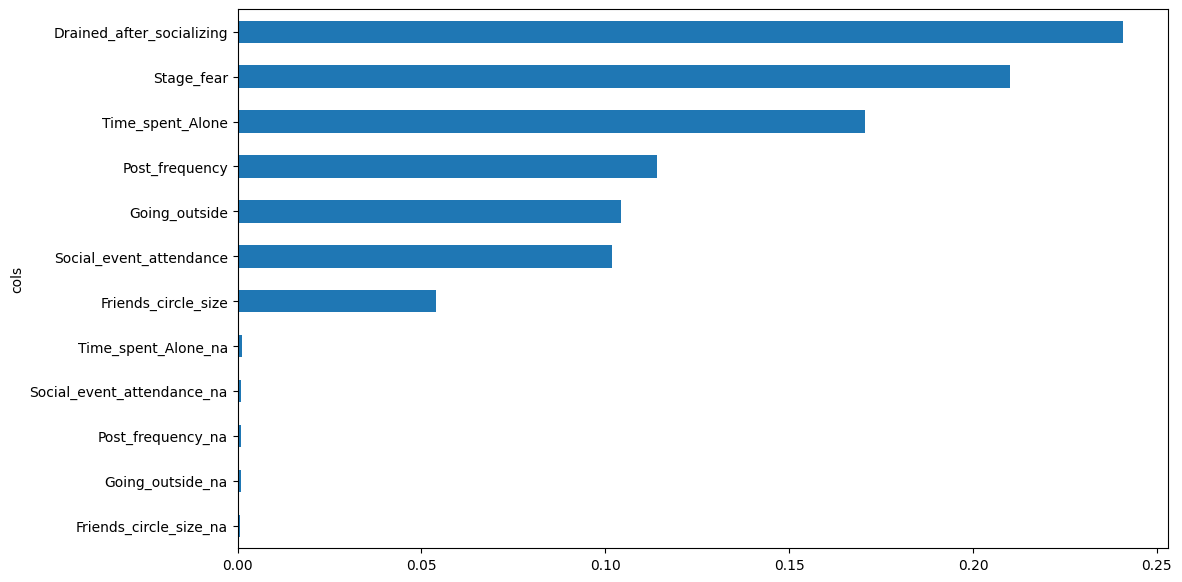

In [70]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [71]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in rf_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### XGBoost

##### Single Fold¶

In [72]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 255 ms, sys: 3.02 ms, total: 258 ms
Wall time: 153 ms


0.9659827213822895

In [73]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier
)

Fold 1 AUC: 0.969636
Fold 2 AUC: 0.966599
Fold 3 AUC: 0.967611
Fold 4 AUC: 0.963225
Fold 5 AUC: 0.971660

Mean AUC: 0.967746


In [74]:
xgb_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [75]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [76]:
xgb_mean_score,xgb_fold_scores

(0.9677462887989204,
 [0.9696356275303644,
  0.9665991902834008,
  0.9676113360323887,
  0.963225371120108,
  0.97165991902834])

In [77]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((14820,), torch.Size([6175]), 0.9677462887989204)

In [78]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in xgb_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### LGBM

In [79]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Info] Number of positive: 3836, number of negative: 10984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258839 -> initscore=-1.052010
[LightGBM] [Info] Start training from score -1.052010
CPU times: user 309 ms, sys: 13 ms, total: 322 ms
Wall time: 194 ms


0.9665226781857451

In [80]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier
)

[LightGBM] [Info] Number of positive: 3068, number of negative: 8788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258772 -> initscore=-1.052361
[LightGBM] [Info] Start training from score -1.052361
Fold 1 AUC: 0.971323
[LightGBM] [Info] Number of positive: 3069, number of negative: 8787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[Ligh

In [81]:
lgbm_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [82]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [83]:
lgbm_mean_score,lgbm_fold_scores

(0.9686234817813766,
 [0.9713225371120108,
  0.967948717948718,
  0.9682860998650472,
  0.9639001349527665,
  0.97165991902834])

In [84]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((14820,), torch.Size([6175]), 0.9686234817813766)

In [85]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Info] Number of positive: 3452, number of negative: 9886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258809 -> initscore=-1.052166
[LightGBM] [Info] Start training from score -1.052166
Fold 1 AUC: 0.970310391363023
[LightGBM] [Info] Number of positive: 3452, number of negative: 9886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features:

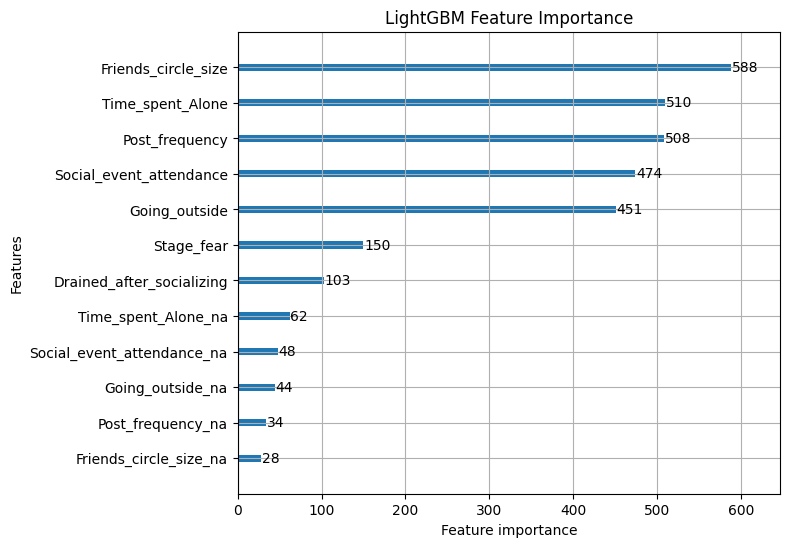

In [86]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

In [87]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in lgbm_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### CatBoost

In [88]:
%%time
#using full ds
cat_model_params = CatBoostClassifier()
cat_model_params = cat_model_params.fit(X_train, y_train, verbose=False)


cat_preds_params = tensor(cat_model_params.predict(test_dl.xs))

cat_preds_x_params = tensor(cat_model_params.predict(X_test))

cat_score_params = accuracy_score(y_test,cat_preds_x_params)
cat_score_params

CPU times: user 12.4 s, sys: 2.59 s, total: 15 s
Wall time: 4.21 s


0.9662526997840173

In [89]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 12.2 s, sys: 2.29 s, total: 14.5 s
Wall time: 3.86 s


0.9662526997840173

In [90]:
cat_oof_preds_y, cat_submission_preds_y, cat_mean_score_y, cat_fold_scores_y = cross_val_predict(
    model_class=CatBoostClassifier,
    
)

Learning rate set to 0.029615
0:	learn: 0.6449364	total: 4.08ms	remaining: 4.08s
1:	learn: 0.6006080	total: 6.76ms	remaining: 3.38s
2:	learn: 0.5609794	total: 9.83ms	remaining: 3.27s
3:	learn: 0.5236230	total: 12.9ms	remaining: 3.21s
4:	learn: 0.4900848	total: 16.2ms	remaining: 3.22s
5:	learn: 0.4595072	total: 19.3ms	remaining: 3.19s
6:	learn: 0.4313832	total: 22.3ms	remaining: 3.16s
7:	learn: 0.4059757	total: 25.3ms	remaining: 3.13s
8:	learn: 0.3828234	total: 28.3ms	remaining: 3.12s
9:	learn: 0.3626104	total: 31.4ms	remaining: 3.1s
10:	learn: 0.3441643	total: 34ms	remaining: 3.06s
11:	learn: 0.3264995	total: 37ms	remaining: 3.05s
12:	learn: 0.3110918	total: 39.4ms	remaining: 2.99s
13:	learn: 0.2964993	total: 42.5ms	remaining: 2.99s
14:	learn: 0.2826207	total: 45.7ms	remaining: 3s
15:	learn: 0.2705363	total: 48.4ms	remaining: 2.98s
16:	learn: 0.2594349	total: 51.4ms	remaining: 2.97s
17:	learn: 0.2493545	total: 53.9ms	remaining: 2.94s
18:	learn: 0.2405327	total: 56.4ms	remaining: 2.91s


In [91]:
cat_score_params,cat_score

(0.9662526997840173, 0.9662526997840173)

In [92]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier
)

Learning rate set to 0.029615
0:	learn: 0.6449364	total: 4.47ms	remaining: 4.46s
1:	learn: 0.6006080	total: 7.79ms	remaining: 3.89s
2:	learn: 0.5609794	total: 10.9ms	remaining: 3.62s
3:	learn: 0.5236230	total: 14.1ms	remaining: 3.5s
4:	learn: 0.4900848	total: 17.2ms	remaining: 3.43s
5:	learn: 0.4595072	total: 20.3ms	remaining: 3.37s
6:	learn: 0.4313832	total: 23.7ms	remaining: 3.35s
7:	learn: 0.4059757	total: 26.7ms	remaining: 3.31s
8:	learn: 0.3828234	total: 30.1ms	remaining: 3.31s
9:	learn: 0.3626104	total: 33.6ms	remaining: 3.32s
10:	learn: 0.3441643	total: 36.4ms	remaining: 3.27s
11:	learn: 0.3264995	total: 39.8ms	remaining: 3.28s
12:	learn: 0.3110918	total: 42.3ms	remaining: 3.21s
13:	learn: 0.2964993	total: 45.5ms	remaining: 3.21s
14:	learn: 0.2826207	total: 48.8ms	remaining: 3.2s
15:	learn: 0.2705363	total: 51.5ms	remaining: 3.16s
16:	learn: 0.2594349	total: 54.5ms	remaining: 3.15s
17:	learn: 0.2493545	total: 56.9ms	remaining: 3.1s
18:	learn: 0.2405327	total: 59.3ms	remaining: 3

In [93]:
cat_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [94]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [95]:
cat_mean_score,cat_mean_score_y

(0.9689608636977057, 0.9689608636977057)

In [96]:
cat_mean_score,cat_mean_score_y

(0.9689608636977057, 0.9689608636977057)

In [97]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((14820,), torch.Size([6175]), 0.9689608636977057)

In [98]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.031142
0:	learn: 0.6419968	total: 4.24ms	remaining: 4.24s
1:	learn: 0.5952345	total: 7.28ms	remaining: 3.63s
2:	learn: 0.5536786	total: 10.7ms	remaining: 3.54s
3:	learn: 0.5148150	total: 14.2ms	remaining: 3.54s
4:	learn: 0.4800807	total: 17.6ms	remaining: 3.5s
5:	learn: 0.4485856	total: 20.8ms	remaining: 3.45s
6:	learn: 0.4197047	total: 24.1ms	remaining: 3.41s
7:	learn: 0.3938017	total: 27.2ms	remaining: 3.38s
8:	learn: 0.3703478	total: 30.6ms	remaining: 3.37s
9:	learn: 0.3499081	total: 33.7ms	remaining: 3.33s
10:	learn: 0.3313938	total: 36.6ms	remaining: 3.29s
11:	learn: 0.3138122	total: 40ms	remaining: 3.29s
12:	learn: 0.2984632	total: 42.4ms	remaining: 3.22s
13:	learn: 0.2840824	total: 45.9ms	remaining: 3.23s
14:	learn: 0.2709069	total: 49.3ms	remaining: 3.24s
15:	learn: 0.2591053	total: 52.1ms	remaining: 3.21s
16:	learn: 0.2479938	total: 55.5ms	remaining: 3.21s
17:	learn: 0.2382101	total: 58ms	remaining: 3.16s
18:	learn: 0.2297422	total: 60.5ms	remaining: 3.1

In [99]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Time_spent_Alone, Importance: 8.25
Feature: Stage_fear, Importance: 6.19
Feature: Social_event_attendance, Importance: 2.85
Feature: Going_outside, Importance: 1.88
Feature: Drained_after_socializing, Importance: 1.97
Feature: Friends_circle_size, Importance: 0.54
Feature: Post_frequency, Importance: 1.28
Feature: Personality, Importance: 15.13


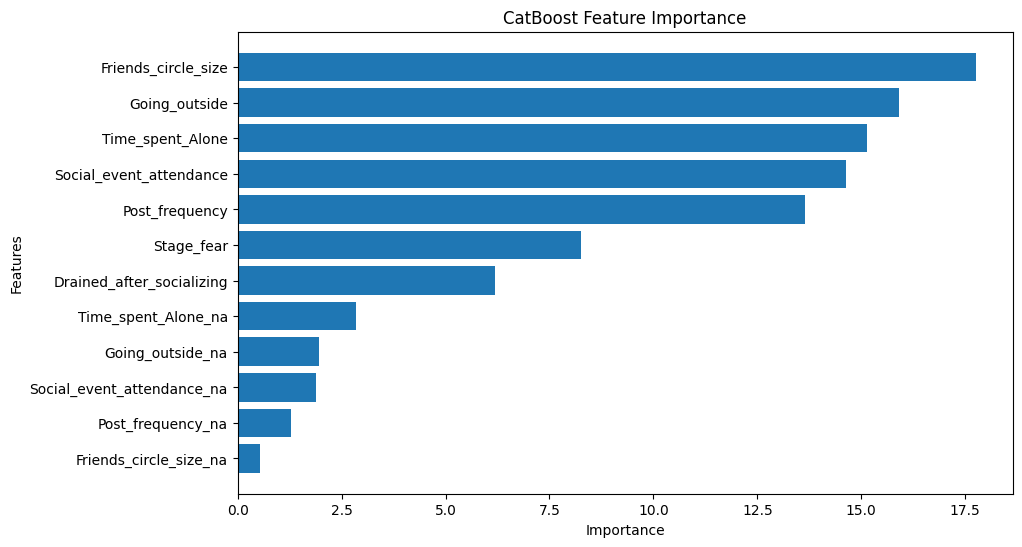

In [100]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [101]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in cat_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


## Ranking

In [102]:
accuracy = pd.DataFrame({
    'algorithm': ['Random Forest',
                  'RF CV','XGBoost','XGBoost CV','LGBM','LGBM CV','CatBoost','CatBoost CV',
                 ],
    'accuracy': [rf_mean_score,rf_score,xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
7,CatBoost CV,0.968961
5,LGBM CV,0.968623
0,Random Forest,0.968286
3,XGBoost CV,0.967746
4,LGBM,0.966523
1,RF CV,0.966523
6,CatBoost,0.966253
2,XGBoost,0.965983
